In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import sys
print(sys.version)

3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]


In [4]:
!git clone https://github.com/mannadamay12/tile2net-segD
%cd tile2net-segD

Cloning into 'tile2net-segD'...
remote: Enumerating objects: 2329, done.
remote: Counting objects: 100% (1148/1148), done.
remote: Compressing objects: 100% (303/303), done.
remote: Total 2329 (delta 964), reused 845 (delta 845), pack-reused 1181 (from 2)
Receiving objects: 100% (2329/2329), 3.58 MiB | 20.25 MiB/s, done.
Resolving deltas: 100% (1435/1435), done.
/kaggle/working/tile2net-segD


In [5]:
!pip install -e .

Obtaining file:///kaggle/working/tile2net-segD
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of opencv-python to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 475.4 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 36.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 338.4/338.4 kB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.6/84.6 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 85.7 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 28.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101

In [6]:
import torch
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"GPU: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'None'}")

CUDA available: True
GPU: Tesla T4


In [7]:
import torch
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import sys

In [8]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 57.1 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44284 sha256=648cbdc628c2a05b35a2458877e0d84e428894a3aba5c4c2d82ac7304d42bcdf
  Stored in directory: /root/.cache/pip/wheels/bc/52/78/893c3b94279ef238f43a9e89608af648de401b96415bebbd1f
Successfully built grad-cam


In [9]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import SemanticSegmentationTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

In [14]:
!bash ./examples/example.sh < <(echo "")

Please enter the output directory:
Tile generation will now begin.
INFO       NumExpr defaulting to 4 threads.
INFO       NumExpr defaulting to 4 threads.
INFO       Using Massachusetts as the source at location=(42.3536483721, -71.0716891532, 42.3555518995, -71.0643742337)
INFO       Using base_tilesize=256 from source
INFO       Stitching 12 tiles...
INFO       96 tiles missing out of 96 total.
INFO       All 96 tiles are on disk.
           Stitching 6 tiles...                   : 100%|█| 6/6 [00:00<00:00, 10
INFO       Dumping to /tmp/tile2net/example/tiles/example_256_info.json
INFO       Inferencing. Segmentation results will not be saved.
INFO       Downloading weights for segmentation, this may take a while...
INFO       Weights downloaded.
INFO       Using a single GPU.
INFO       Using Per Image based weighted loss
INFO       Using Cross Entropy Loss
INFO       Loading weights from: checkpoint=/kaggle/working/tile2net-segD/src/tile2net/raster/resources/assets/weights/satellit

In [16]:
import json

city_info_path = "/tmp/tile2net/example/tiles/example_256_info.json"
with open(city_info_path) as f:
    city_info = json.load(f)

# See what keys exist
print("Available keys:")
print(json.dumps(city_info, indent=2))

Available keys:
{
  "name": "example",
  "bbox": [
    42.3519474764,
    42.3560069067,
    -71.0719299316,
    -71.0636901855
  ],
  "location": [
    42.3536483721,
    -71.0716891532,
    42.3555518995,
    -71.0643742337
  ],
  "size": 1024,
  "zoom": 19,
  "crs": 4326,
  "tile_step": 4,
  "project": {
    "config": "/kaggle/working/tile2net-segD/src/tile2net/tileseg/config.py",
    "assets": {
      "weights": {
        "satellite_2021": "/kaggle/working/tile2net-segD/src/tile2net/raster/resources/assets/weights/satellite_2021.pth",
        "hrnetv2_w48_imagenet_pretrained": "/kaggle/working/tile2net-segD/src/tile2net/raster/resources/assets/weights/hrnetv2_w48_imagenet_pretrained.pth"
      }
    },
    "segmentation": "/tmp/tile2net/example/segmentation/example/256_19_4",
    "tiles": {
      "info": "/tmp/tile2net/example/tiles/example_256_info.json",
      "static": "/tmp/tile2net/example/tiles/static/ma/256_19",
      "stitched": "/tmp/tile2net/example/tiles/stitched/256_19_

In [40]:
import sys
import os
sys.path.insert(0, '/kaggle/working/tile2net-segD/src')

import torch
from tile2net.tileseg.network.ocrnet import MscaleOCR
from tile2net.tileseg.config import cfg

# Set config
cfg.MODEL.ARCH = 'ocrnet.HRNet_Mscale'
cfg.DATASET.NUM_CLASSES = 4
cfg.MODEL.OCR.MID_CHANNELS = 512
cfg.MODEL.OCR.KEY_CHANNELS = 256
cfg.MODEL.BNFUNC = torch.nn.BatchNorm2d
cfg.MODEL.HRNET_CHECKPOINT = '/kaggle/working/tile2net-segD/src/tile2net/raster/resources/assets/weights/hrnetv2_w48_imagenet_pretrained.pth'

checkpoint_path = '/kaggle/working/tile2net-segD/src/tile2net/raster/resources/assets/weights/satellite_2021.pth'

# Create model
net = MscaleOCR(num_classes=4, trunk='hrnetv2', criterion=None)

checkpoint = torch.load(checkpoint_path, map_location='cpu', weights_only=False)
state_dict = checkpoint['state_dict']

from collections import OrderedDict
new_state_dict = OrderedDict()
for k, v in state_dict.items():
  name = k[7:] if k.startswith('module.') else k
  new_state_dict[name] = v

net.load_state_dict(new_state_dict)
net = net.cuda().eval()

print("\nModel loaded successfully!")
print(f"Model type: {type(net)}")
print(f"Model on CUDA: {next(net.parameters()).is_cuda}")

INFO       init weights from normal distribution
INFO       loading pretrained model /kaggle/working/tile2net-segD/src/tile2net/raster/resources/assets/weights/hrnetv2_w48_imagenet_pretrained.pth
INFO       Trunk: hrnetv2



✓ Model loaded successfully!
Model type: <class 'tile2net.tileseg.network.ocrnet.MscaleOCR'>
Model on CUDA: True


In [43]:
from pathlib import Path
import os

# Check the specific tile directories
static_dir = Path('/tmp/tile2net/example/tiles/static/ma/256_19')
stitched_dir = Path('/tmp/tile2net/example/tiles/stitched/256_19_4')

print("Static tiles directory:")
print(f"  Path: {static_dir}")
print(f"  Exists: {static_dir.exists()}")
if static_dir.exists():
  files = list(static_dir.iterdir())
  print(f"  Files: {len(files)}")
  if files:
      print(f"  First 5: {[f.name for f in files[:5]]}")
  else:
      print("  (empty directory)")

print("\nStitched tiles directory:")
print(f"  Path: {stitched_dir}")
print(f"  Exists: {stitched_dir.exists()}")
if stitched_dir.exists():
  files = list(stitched_dir.iterdir())
  print(f"  Files: {len(files)}")
  if files:
      print(f"  First 5: {[f.name for f in files[:5]]}")
  else:
      print("  (empty directory)")

# Also check for JPG files
print("\nChecking for other image formats...")
base = Path('/tmp/tile2net/example')
jpgs = list(base.rglob('*.jpg'))
jpegs = list(base.rglob('*.jpeg'))
print(f"  JPG files: {len(jpgs)}")
print(f"  JPEG files: {len(jpegs)}")

if jpgs or jpegs:
  sample = (jpgs + jpegs)[0]
  print(f"  Sample: {sample}")

Static tiles directory:
  Path: /tmp/tile2net/example/tiles/static/ma/256_19
  Exists: True
  Files: 96
  First 5: ['158641_193925.jpg', '158644_193928.jpg', '158642_193925.jpg', '158644_193927.jpg', '158644_193932.jpg']

Stitched tiles directory:
  Path: /tmp/tile2net/example/tiles/stitched/256_19_4
  Exists: True
  Files: 6
  First 5: ['2_1_5.jpg', '0_1_1.jpg', '1_1_3.jpg', '2_0_4.jpg', '1_0_2.jpg']

Checking for other image formats...
  JPG files: 102
  JPEG files: 0
  Sample: /tmp/tile2net/example/tiles/static/ma/256_19/158641_193925.jpg


Loading: /tmp/tile2net/example/tiles/stitched/256_19_4/2_1_5.jpg
Image shape: (1024, 1024, 3)
Image size: (1024, 1024)
Input shape: torch.Size([1, 3, 1024, 1024])
Input range: [-1.912, 2.640]


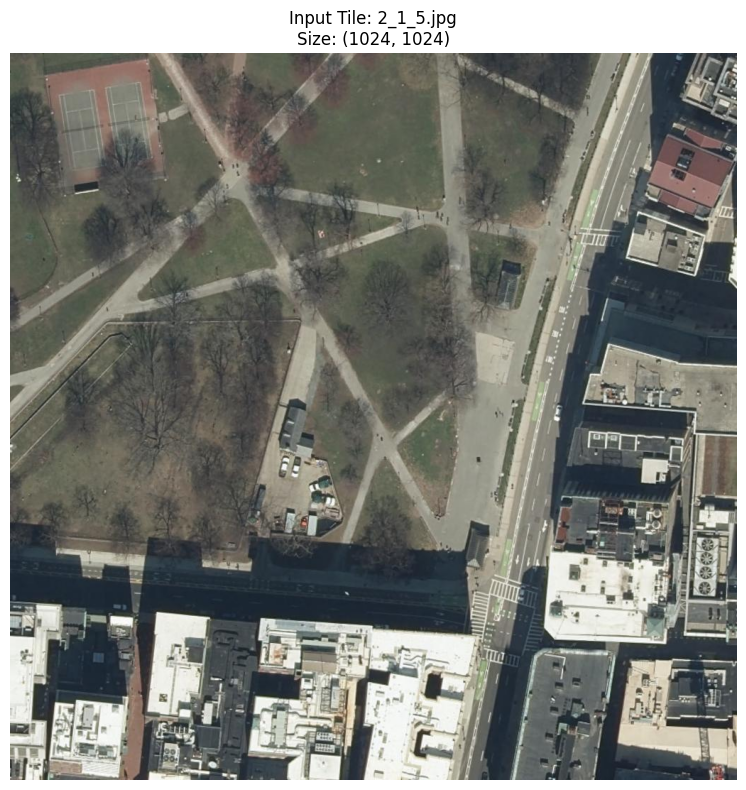

In [44]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
from pathlib import Path

# Use stitched tiles (larger, better context)
stitched_dir = Path('/tmp/tile2net/example/tiles/stitched/256_19_4')
tile_path = list(stitched_dir.glob('*.jpg'))[0]

print(f"Loading: {tile_path}")

# Load image
img = Image.open(tile_path).convert('RGB')
img_array = np.array(img)

print(f"Image shape: {img_array.shape}")
print(f"Image size: {img.size}")

# Prepare for model (Tile2Net preprocessing)
img_normalized = img_array.astype(np.float32) / 255.0

transform = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.485, 0.456, 0.406],
                     std=[0.229, 0.224, 0.225])
])

input_tensor = transform(img).unsqueeze(0).cuda()

print(f"Input shape: {input_tensor.shape}")
print(f"Input range: [{input_tensor.min():.3f}, {input_tensor.max():.3f}]")

# Visualize
plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.title(f"Input Tile: {tile_path.name}\nSize: {img.size}")
plt.axis('off')
plt.tight_layout()
plt.show()

In [48]:
  # Fix missing config values that are needed for inference
  from tile2net.namespace import torch_version_float

  # Set required config values
  cfg.OPTIONS.TORCH_VERSION = torch_version_float()
  cfg.MODEL.MSCALE = True  # MscaleOCR uses multi-scale
  cfg.MODEL.MSCALE_LO_SCALE = 0.5  # Default low-res scale

  print(f"Torch version: {cfg.OPTIONS.TORCH_VERSION}")
  print(f"Multi-scale enabled: {cfg.MODEL.MSCALE}")
  print(f"Low-res scale: {cfg.MODEL.MSCALE_LO_SCALE}")
  print("\n✓ Config fixed!")

Torch version: 2.6
Multi-scale enabled: True
Low-res scale: 0.5

✓ Config fixed!


Running inference...
Output shape: torch.Size([1, 4, 1024, 1024])


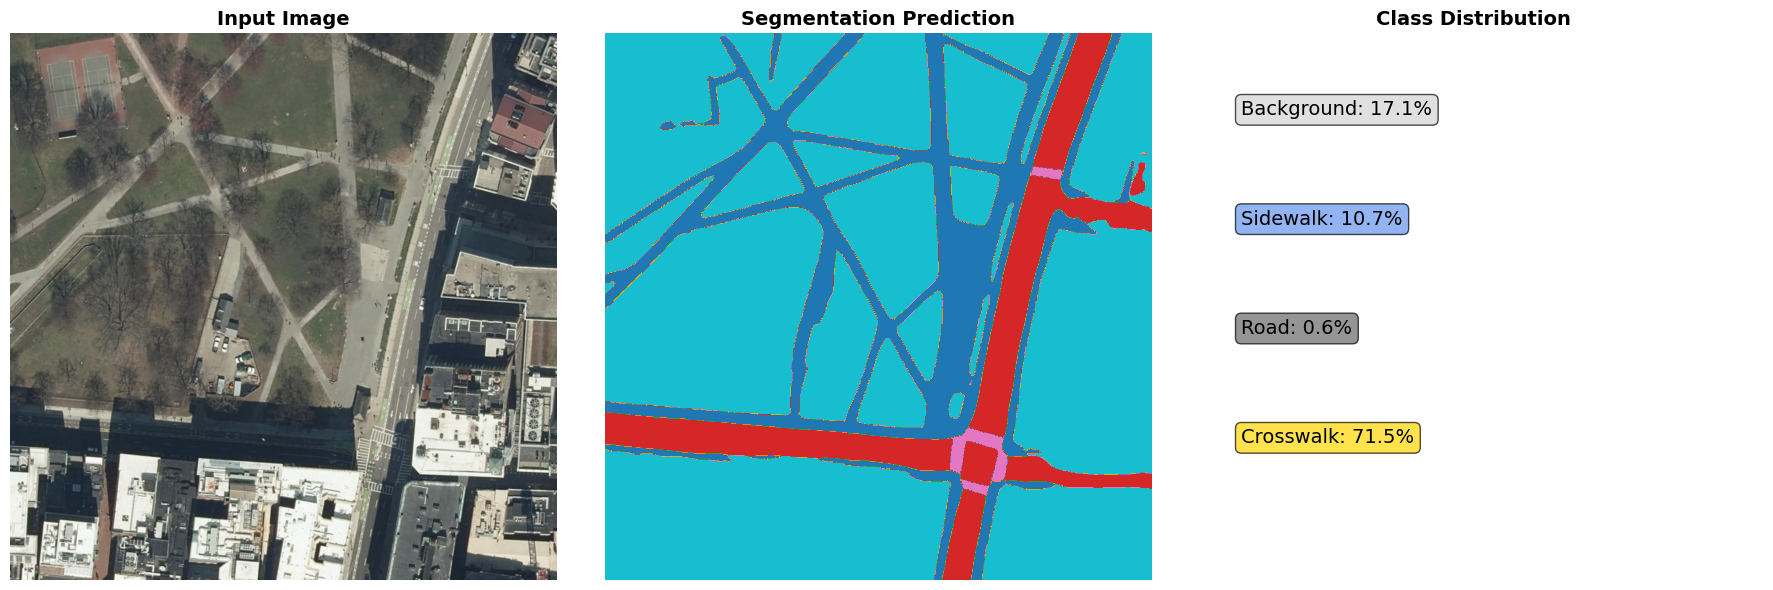


✓ Inference complete!
Unique classes in prediction: [0 1 2 3]


In [49]:
# Run model
print("Running inference...")
with torch.no_grad():
  output = net({'images': input_tensor})

# Handle output
if isinstance(output, dict):
  pred_logits = output.get('pred', output.get('out', list(output.values())[0]))
else:
  pred_logits = output

print(f"Output shape: {pred_logits.shape}")

# Get prediction mask
pred_mask = pred_logits.argmax(dim=1).cpu().numpy()[0]

# Visualize
class_names = ['Background', 'Sidewalk', 'Road', 'Crosswalk']
class_colors = ['lightgray', 'cornflowerblue', 'dimgray', 'gold']

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Input
axes[0].imshow(img)
axes[0].set_title('Input Image', fontsize=14, fontweight='bold')
axes[0].axis('off')

# Prediction
im = axes[1].imshow(pred_mask, cmap='tab10', vmin=0, vmax=3)
axes[1].set_title('Segmentation Prediction', fontsize=14, fontweight='bold')
axes[1].axis('off')

# Stats
axes[2].axis('off')
axes[2].set_xlim(0, 1)
axes[2].set_ylim(0, 1)
for i in range(4):
  mask = pred_mask == i
  pct = mask.sum() / mask.size * 100
  axes[2].text(0.1, 0.85 - i*0.2,
              f"{class_names[i]}: {pct:.1f}%",
              fontsize=14,
              bbox=dict(boxstyle='round', facecolor=class_colors[i], alpha=0.7,
edgecolor='black'))
axes[2].set_title('Class Distribution', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nInference complete!")
print(f"Unique classes in prediction: {np.unique(pred_mask)}")

In [50]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import SemanticSegmentationTarget

# Inspect HRNet structure
print("=" * 70)
print("HRNet-W48 Backbone Structure for GradCAM")
print("=" * 70)

stage_info = {}
for name, module in net.backbone.named_children():
  if 'stage' in name or 'transition' in name:
      print(f"\n{name}: {type(module).__name__}")
      if hasattr(module, '__len__'):
          print(f"  Num blocks: {len(module)}")
          if 'stage' in name and hasattr(module[-1], 'branches'):
              num_branches = len(module[-1].branches)
              print(f"  Branches: {num_branches} (multi-resolution)")
              stage_info[name] = num_branches
              for i, branch in enumerate(module[-1].branches):
                  print(f"    Branch {i}: {len(branch)} blocks")

print("\n" + "=" * 70)
print("Recommended GradCAM Target Layers:")
print("=" * 70)
print("  stage2: 2 branches (high-res + low-res)")
print("  stage3: 3 branches (high + mid + low res)")
print("  stage4: 4 branches (multi-scale fusion)")
print("\nWe'll visualize how each stage focuses on different features!")
print("=" * 70)

HRNet-W48 Backbone Structure for GradCAM

transition1: ModuleList
  Num blocks: 2

stage2: Sequential
  Num blocks: 1
  Branches: 2 (multi-resolution)
    Branch 0: 4 blocks
    Branch 1: 4 blocks

transition2: ModuleList
  Num blocks: 3

stage3: Sequential
  Num blocks: 4
  Branches: 3 (multi-resolution)
    Branch 0: 4 blocks
    Branch 1: 4 blocks
    Branch 2: 4 blocks

transition3: ModuleList
  Num blocks: 4

stage4: Sequential
  Num blocks: 3
  Branches: 4 (multi-resolution)
    Branch 0: 4 blocks
    Branch 1: 4 blocks
    Branch 2: 4 blocks
    Branch 3: 4 blocks

Recommended GradCAM Target Layers:
  stage2: 2 branches (high-res + low-res)
  stage3: 3 branches (high + mid + low res)
  stage4: 4 branches (multi-scale fusion)

We'll visualize how each stage focuses on different features!


Generating GradCAM for class: Sidewalk
Class coverage: 10.7%
Processing Stage2-HighRes...
Processing Stage2-LowRes...
Processing Stage3-HighRes...
Processing Stage3-MidRes...
Processing Stage4-HighRes...
Processing Stage4-LowRes...


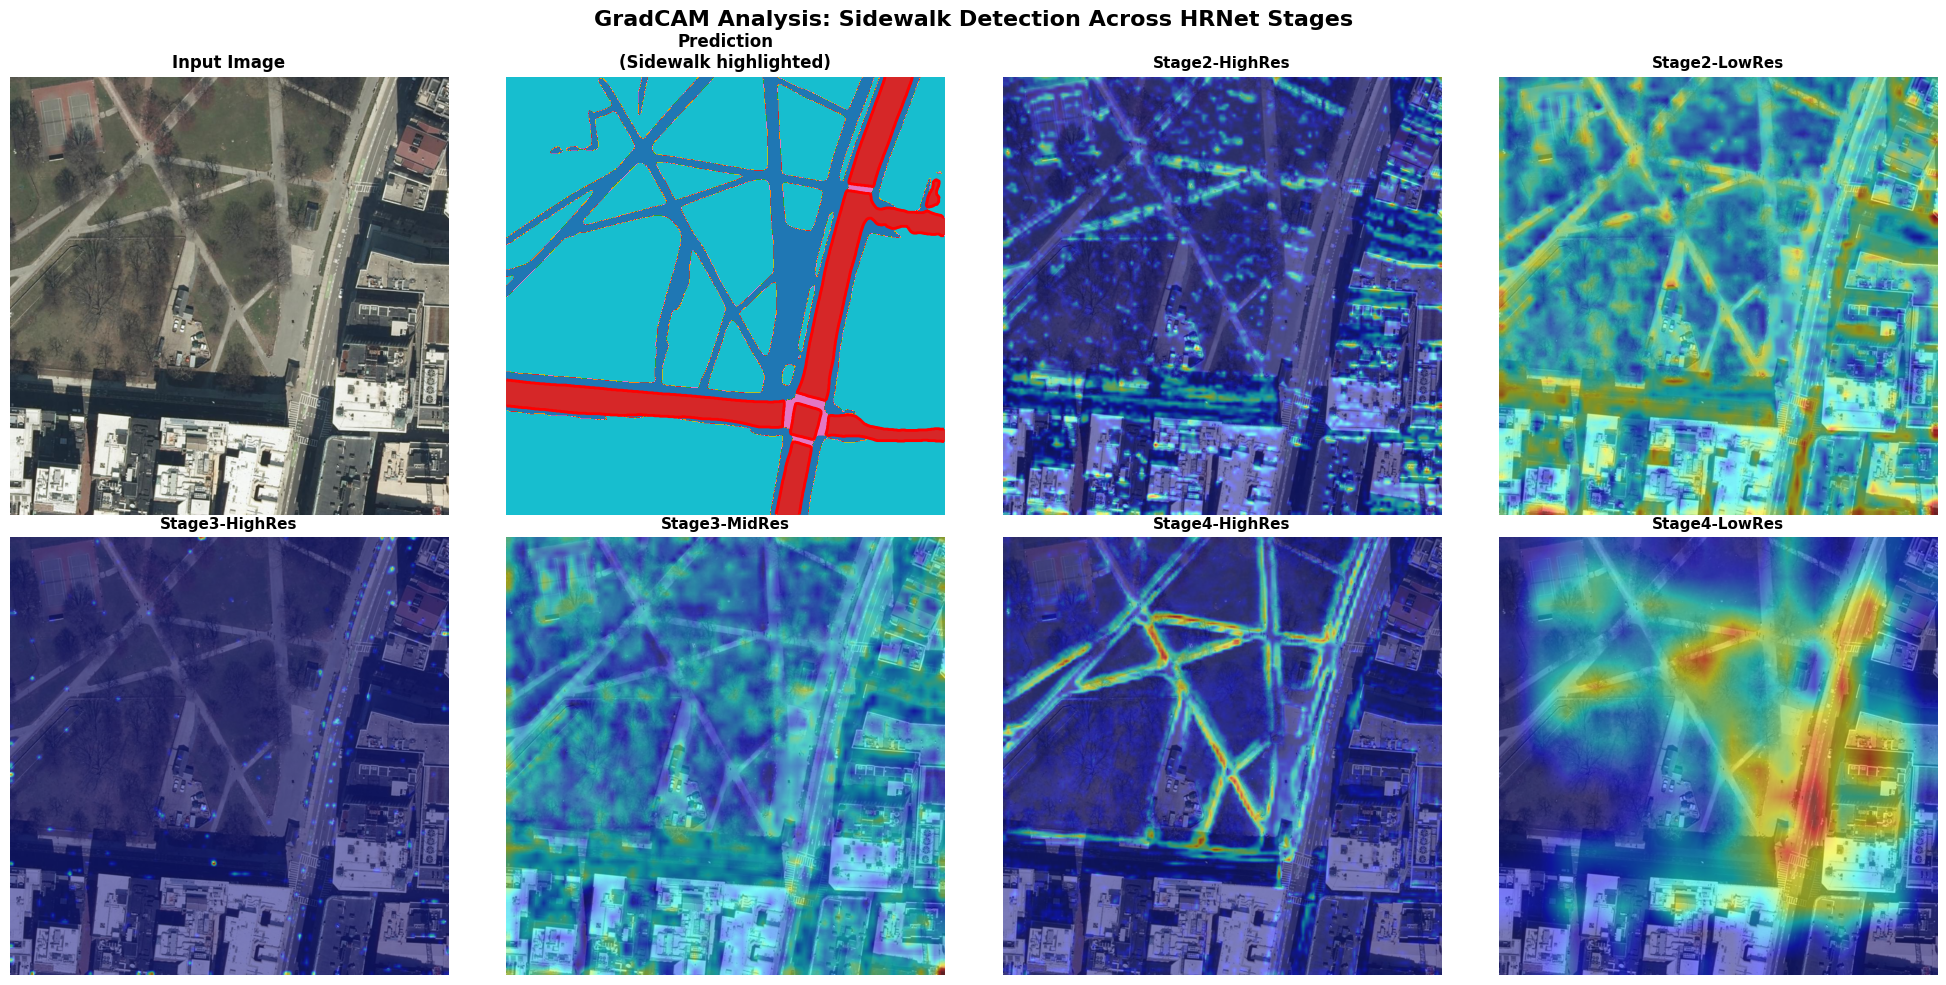


✓ GradCAM visualization complete!


In [54]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import SemanticSegmentationTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import torch.nn as nn

# Choose a class to explain (1=Sidewalk is usually interesting)
target_class = 1  # Sidewalk
class_mask = (pred_mask == target_class)

print(f"Generating GradCAM for class: {class_names[target_class]}")
print(f"Class coverage: {class_mask.sum() / class_mask.size * 100:.1f}%")

# Create a wrapper model that returns only the prediction tensor
class ModelWrapper(nn.Module):
  def __init__(self, model):
      super().__init__()
      self.model = model

  def forward(self, x):
      output = self.model({'images': x})
      # Return only the prediction logits (what GradCAM expects)
      if isinstance(output, dict):
          return output.get('pred', output.get('out', list(output.values())[0]))
      return output

wrapped_net = ModelWrapper(net)
wrapped_net.eval()

# Copy the backbone reference for GradCAM to access
wrapped_net.backbone = net.backbone

# Define target layers from different HRNet stages
target_layers_dict = {
  'Stage2-HighRes': [wrapped_net.backbone.stage2[-1].branches[0][-1]],
  'Stage2-LowRes': [wrapped_net.backbone.stage2[-1].branches[1][-1]],
  'Stage3-HighRes': [wrapped_net.backbone.stage3[-1].branches[0][-1]],
  'Stage3-MidRes': [wrapped_net.backbone.stage3[-1].branches[1][-1]],
  'Stage4-HighRes': [wrapped_net.backbone.stage4[-1].branches[0][-1]],
  'Stage4-LowRes': [wrapped_net.backbone.stage4[-1].branches[3][-1]],
}

# Prepare target for GradCAM
targets = [SemanticSegmentationTarget(target_class, class_mask)]

# Generate CAMs
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

# Original image
axes[0].imshow(img)
axes[0].set_title('Input Image', fontsize=12, fontweight='bold')
axes[0].axis('off')

# Prediction with target class highlighted
axes[1].imshow(pred_mask, cmap='tab10', vmin=0, vmax=3)
axes[1].contour(class_mask, colors='red', linewidths=2)
axes[1].set_title(f'Prediction\n({class_names[target_class]} highlighted)',
               fontsize=12, fontweight='bold')
axes[1].axis('off')

# Generate GradCAM for each layer
for idx, (name, layers) in enumerate(target_layers_dict.items(), start=2):
  print(f"Processing {name}...")

  try:
      cam = GradCAM(model=wrapped_net, target_layers=layers)
      grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]

      # Overlay on image
      cam_image = show_cam_on_image(img_normalized, grayscale_cam, use_rgb=True)

      axes[idx].imshow(cam_image)
      axes[idx].set_title(f'{name}', fontsize=11, fontweight='bold')
      axes[idx].axis('off')

      # Clean up
      del cam

  except Exception as e:
      print(f"  Error: {type(e).__name__}: {e}")
      axes[idx].text(0.5, 0.5, f'Error:\n{type(e).__name__}',
                    ha='center', va='center', fontsize=10)
      axes[idx].axis('off')

plt.suptitle(f'GradCAM Analysis: {class_names[target_class]} Detection Across HRNet Stages',
           fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

print("\n✓ GradCAM visualization complete!")